# Capstone Project - Setting new Stock Benchmarks 

See README.md for details on the project

Andro Tikvica

Last Updated: 22/10/2021

### Importing Libraries

In [1149]:
# Primary Libraries
import urllib, json
import urllib3
import requests
import pandas as pd
from io import StringIO
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# settings to display all columns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# Clustering Libraries
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.metrics import calinski_harabasz_score, adjusted_rand_score
from clusteval import clusteval
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import KernelDensity
import scipy.cluster.hierarchy as shc


# Linear Regression stuff
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, KFold
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols

import warnings
warnings.filterwarnings("ignore")

# Sourcing Data

## Finding All stocks on NYSE and NASDAQ

Data was sourced from <https://www.alphavantage.co/>

The NYSE and NASDAQ information was downloaded as a csv file and can be found in the GitHub Repo.

In [42]:
NYSE = pd.read_csv('data/NYSE_LIST_OF_SYMBOLS.csv')
NASDAQ = pd.read_csv('data/NASDAQ_LIST_OF_SYMBOLS.csv')

stock_list = pd.concat([NYSE, NASDAQ])

In [43]:
stock_list.head()

,Code,Name,Country,Exchange,Currency,Type,Isin
0,A,Agilent Technologies Inc,USA,NYSE,USD,Common Stock,US00846U1016
1,AA,Alcoa Corporation,USA,NYSE,USD,Common Stock,US0138721065
2,AAA,Listed Funds Trust - AAF First Priority CLO Bo...,USA,NYSE ARCA,USD,ETF,NaN
3,AAAU,Goldman Sachs Physical Gold ETF,USA,NYSE ARCA,USD,ETF,US7154261025
4,AAC,Ares Acquisition Corporation,USA,NYSE,USD,Common Stock,KYG330321061


In [44]:
stock_list.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11005 entries, 0 to 5263
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Code      11005 non-null  object
 1   Name      11003 non-null  object
 2   Country   11003 non-null  object
 3   Exchange  11003 non-null  object
 4   Currency  11003 non-null  object
 5   Type      11003 non-null  object
 6   Isin      8539 non-null   object
dtypes: object(7)
memory usage: 687.8+ KB


In [45]:
stock_list.Type.value_counts()

Common Stock       8029
ETF                2171
FUND                442
Preferred Share     328
Mutual Fund          22
Fund                  8
Preferred Stock       2
BOND                  1
Name: Type, dtype: int64

In [46]:
stocks = stock_list[stock_list['Type'] == 'Common Stock'].sort_values(by='Code')
stocks.shape

(8029, 7)

In [47]:
stocks.to_csv('data/stock_tickers')

## Downloading Stock Info


In [ ]:
## API Keys Removed

In [ ]:
# base_data = pd.DataFrame(columns = ['Symbol', 'AssetType', 'Name', 'Description', 'CIK', 'Exchange', 
#                                     'Currency', 'Country', 'Sector', 'Industry', 'Address', 'FiscalYearEnd', 
#                                     'LatestQuarter', 'MarketCapitalization', 'EBITDA', 'PERatio', 'PEGRatio', 
#                                     'BookValue', 'DividendPerShare', 'DividendYield', 'EPS', 'RevenuePerShareTTM', 
#                                     'ProfitMargin', 'OperatingMarginTTM', 'ReturnOnAssetsTTM', 'ReturnOnEquityTTM', 
#                                     'RevenueTTM', 'GrossProfitTTM', 'DilutedEPSTTM', 'QuarterlyEarningsGrowthYOY', 
#                                     'QuarterlyRevenueGrowthYOY', 'AnalystTargetPrice', 'TrailingPE', 'ForwardPE', 
#                                     'PriceToSalesRatioTTM', 'PriceToBookRatio', 'EVToRevenue', 'EVToEBITDA', 'Beta', 
#                                     '52WeekHigh', '52WeekLow', '50DayMovingAverage', '200DayMovingAverage', 
#                                     'SharesOutstanding', 'SharesFloat', 'SharesShort', 'SharesShortPriorMonth', 
#                                     'ShortRatio', 'ShortPercentOutstanding', 'ShortPercentFloat', 'PercentInsiders', 
#                                     'PercentInstitutions', 'ForwardAnnualDividendRate', 'ForwardAnnualDividendYield', 
#                                     'PayoutRatio', 'DividendDate', 'ExDividendDate', 'LastSplitFactor', 'LastSplitDate'])


In [ ]:
# %%time
# for i in stocks.Code.values[160:]:
#     url = f'https://www.alphavantage.co/query?function=OVERVIEW&symbol={i}&apikey={key_alpha}'
#     r = requests.get(url)
#     data_overview = r.json()
    
#     if data_overview == {}:
#         continue
#     else:
#         base_data = base_data.append(data_overview, ignore_index = True)

In [ ]:
# base_data.to_csv('data/base_data.csv')

## Cleaning Base Stock info

**Justification for dropping columns:**

1. **AssetType** - Since we are only looking at Common Stock Assets we can drop the column
2. **Currency** - All Currencies were USD
3. **Address** - The Headquarters of a company may have some bearing what kind of company it is (think Silicon Valley) but we want to focus more on stock features and performance.
4. **CIK** - Central Index key, is just a unique id for each stock. 
5. **FiscalYearEnd** - The month in which the company registers its year end. I don't think it's a relevant feature for seperating stocks.
6. **LatestQuarter** - 
7. **Industry** - The industry segment was split into too many niche categories (375) and the majority of stocks were saved as "Blank Checks" or "General"
8. **Exchange** - After reading a bit about the difference between the NASDAQ and NYSE and breaking down the .describe of each exchange the key differences seem to be that the biggest stocks (Apple, Microsoft, Alphabet, Amazon, Facebook) are all on the NASDAQ, but also a lot of the smallest stocks are on NASDAQ. May return this column in subsequent iterations, but for now, we are dropping it. 
9. **LastSplitDate** - Turned into two boolean columns: one if the stock has ever split, and two if the stock has split in the last five years. This hopes to seperate out stocks that grew in price far enough that it made sense to split the stock to keep the individual share price at a reasonable amount.
10. **LastSplitFactor** - Removed in favour of Last Split Date. There may be some favour in adding it for showing how high the ratio of a stock split was, but because adding it may skew the data in favour of stocks that have had splits, it was removed. 
11. **Dividend Date** - 
12. **ExDividendDate** - 
13. **DividendPerShare** - Too many null values to try and salvage
14. **TrailingPE** - Price-to-earnings for the actual earnings from the last 12 months. A lot of values are 0 and we already have PERatio as a column
15. **ForwardPE** - Price-to-earnings for the forecasted earnings. Would have been a cool metric but more than 3000 rows have no data for ForwardPE.


**Justification for filling null variables:**

1. **Beta** - Because Beta is a pretty important feature and a lot of cool stocks did not have beta data we filled the remaining null values with normally distributed datapoints with the same mean and std. 

In [1033]:
base_df = pd.read_csv('data/base_data.csv')

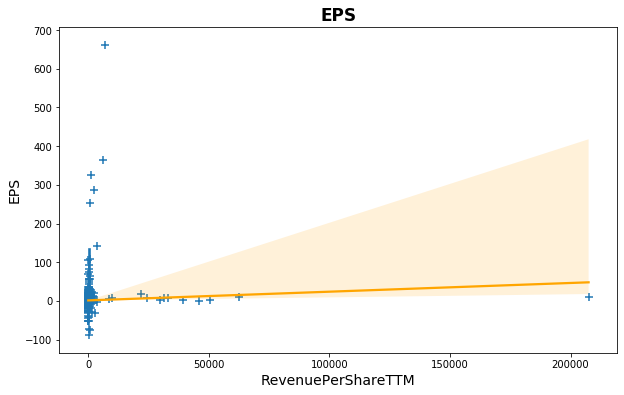

Correlation Coefficient:
 [[1.         0.04362026]
 [0.04362026 1.        ]]


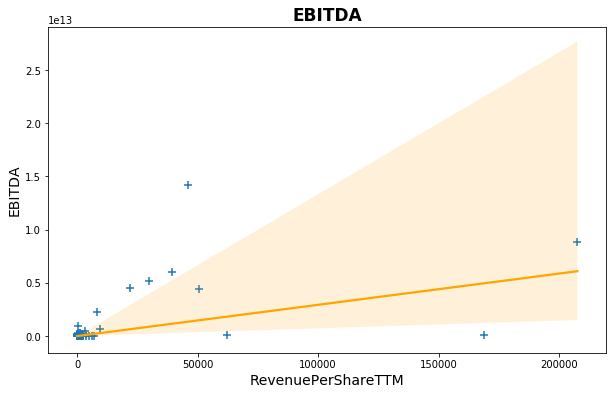

Correlation Coefficient:
 [[1.        0.4960739]
 [0.4960739 1.       ]]


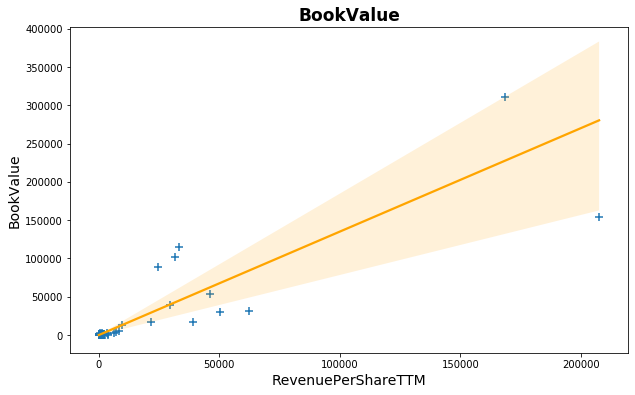

Correlation Coefficient:
 [[1.        0.9027279]
 [0.9027279 1.       ]]


In [1034]:
## Cleaning base_data ##

## Drop all null values by Symbol
base_df.dropna(subset = ['Symbol'], inplace=True)


## Replace all 'None' with Null
for i in ['PERatio', 'PEGRatio', 'BookValue', 'DividendYield', 'EPS', 
          'MarketCapitalization', 'EBITDA', 'Beta', 'AnalystTargetPrice']:
    base_df[i] = base_df[i].replace('None', np.NaN)
    

## FillNa Dividiend Yield with 0
base_df['DividendYield'].fillna(0, inplace=True)
    

## Change to columns to float or int
for i in ['PERatio', 'PEGRatio', 'BookValue', 'DividendYield', 'EPS', 
          'MarketCapitalization', 'EBITDA', 'Beta', 'AnalystTargetPrice']:
    base_df[i] = base_df[i].map(lambda x: float(x))
    
    
## Drop Unnamed: 0
base_df.drop(['Unnamed: 0', 'Information', 'Error Message'], axis = 1, inplace=True)


## Change index name so it's easier to save and re-load
base_df.index.names = ['Index']


## Bin Market Cap
bins = [0, 300000000, 2000000000, 10000000000, 9999999999999]
labels = ['Micro-Cap', 'Small-Cap', 'Mid-Cap', 'Big-Cap']

base_df['Market-Cap'] = pd.cut(base_df['MarketCapitalization'], bins=bins, labels=labels)


## Add columns split_ever and split_last_5_yrs
base_df['split_ever'] = base_df['LastSplitDate'].map(lambda x: 0 if (x == 'None') else 1)

split_last_5_yrs = []
for i in base_df['LastSplitDate']:
    try:
        if int(i[:4]) > 2016:
            split_last_5_yrs.append(1)
        else:
            split_last_5_yrs.append(0)
    except:
        split_last_5_yrs.append(0)
base_df['split_last_5_yrs'] = split_last_5_yrs


## Add columns dividend_ever and dividend_last_3_yrs
base_df['dividend_ever'] = base_df['DividendDate'].map(lambda x: 0 if (x == 'None') else 1)

dividend_last_3_yrs = []
for i in base_df['DividendDate']:
    try:
        if int(i[:4]) > 2018:
            dividend_last_3_yrs.append(1)
        else:
            dividend_last_3_yrs.append(0)
    except:
        dividend_last_3_yrs.append(0)
base_df['dividend_3_yrs'] = dividend_last_3_yrs


## Fill EPS Null values
# Create new df with only EPS not null values 
EPS = base_df[base_df['EPS'].notna()]

# Drop Berkshire Hathway and LILM because of the significant outliers
EPS = EPS[EPS['EPS'] != 68287.15]
EPS = EPS[EPS['Symbol'] != 'LILM']

# Get rid of columns
EPS.drop(['PERatio', 'Beta', 'Market-Cap', 'DividendPerShare', 'DividendYield', 'PEGRatio',
          'EBITDA', 'AnalystTargetPrice'], axis=1, inplace = True)

# Remove object strings
EPS.drop(['Symbol', 'Name', 'Description', 'Country', 'Sector'], axis = 1, inplace=True)

# Remove remaining null rows (only about a hundred)
EPS.dropna(inplace=True)

# Pearson_Corr_matrix(EPS)

EPS_coeff = print_regplot(EPS, 'RevenuePerShareTTM', 'EPS')

EPS_to_add = []
for n,i in enumerate(base_df['EPS']):
    if np.isnan(i):
        EPS_to_add.append(base_df['RevenuePerShareTTM'].iloc[n] * EPS_coeff)
    else: 
        EPS_to_add.append(i)

base_df['EPS'] = EPS_to_add


## Fill beta missing values
Beta = base_df[base_df['Beta'].notna()]

for i in ['EBITDA', 'PERatio', 'PEGRatio', 'BookValue', 'DividendYield']:
    Beta[i] = Beta[i].fillna(Beta[i].mean())
    
Beta.drop(['Symbol', 'Name', 'Description', 'Country', 'Sector', 
           'Market-Cap', 'AnalystTargetPrice'], axis = 1, inplace=True)

# No promising multicollinearity, will resort to filling with normally distributed data
# Pearson_Corr_matrix(Beta)

# Fillna w/normally distributed features
index = base_df[base_df.Beta.isna()].index
value = np.random.normal(loc=base_df.Beta.mean(), scale=base_df.Beta.std(), size=base_df.Beta.isna().sum())

base_df.Beta.fillna(pd.Series(value, index=index), inplace=True)


## Fill EBITDA Missing Values
EBITDA = base_df[base_df['EBITDA'].notna()]

for i in ['PERatio', 'PEGRatio', 'BookValue', 'DividendYield']:
    EBITDA[i] = EBITDA[i].fillna(EBITDA[i].mean())
    
EBITDA.drop(['Symbol', 'Name', 'Description', 'Country', 'Sector', 
           'Market-Cap', 'AnalystTargetPrice'], axis = 1, inplace=True)

# Multicollinearity shows v high correlation with RevenuePerShareTT
EBITDA_coeff = print_regplot(EBITDA, 'RevenuePerShareTTM', 'EBITDA')

EBITDA_to_add = []
for n,i in enumerate(base_df['EBITDA']):
    if np.isnan(i):
        EBITDA_to_add.append(base_df['RevenuePerShareTTM'].iloc[n] * EBITDA_coeff)
    else: 
        EBITDA_to_add.append(i)

base_df['EBITDA'] = EBITDA_to_add


## Remove  Market Capitalization null values 
base_df = base_df[base_df['MarketCapitalization'].notna()]


## Fill PERatio
# Use the mean for market-cap and sector and apply to each null P/E ratio
grouped_PER = base_df[['PERatio','Market-Cap', 'Sector']].groupby(by=['Market-Cap', 'Sector'], as_index=False).mean()

PER = []
for n,i in enumerate(base_df['PERatio']):
    if np.isnan(i):
        PER.append(grouped_PER['PERatio'][(grouped_PER['Market-Cap']== base_df['Market-Cap'].iloc[n]) & 
                                          (grouped_PER['Sector']== base_df['Sector'].iloc[n])].item())
    else:
        PER.append(i)
        
base_df['PERatio'] = PER


## Fill PEGRatio
# Same Principle as PERatio
grouped_PEG = base_df[['PEGRatio','Market-Cap', 'Sector']].groupby(by=['Market-Cap', 'Sector'], as_index=False).mean()

PEG = []
for n,i in enumerate(base_df['PEGRatio']):
    if np.isnan(i):
        PEG.append(grouped_PEG['PEGRatio'][(grouped_PEG['Market-Cap']== base_df['Market-Cap'].iloc[n]) & 
                                          (grouped_PEG['Sector']== base_df['Sector'].iloc[n])].item())
    else:
        PEG.append(i)
        
base_df['PEGRatio'] = PEG


## ShortInterest Month on Month
base_df.reset_index(drop = True, inplace=True)
base_df['ShortInterestMonthDelta'] = (base_df['SharesShort']- base_df['SharesShortPriorMonth'])/base_df['SharesShortPriorMonth']
shortinterestinf = [i for i in base_df['ShortInterestMonthDelta'][base_df['ShortInterestMonthDelta']> 1000000].index]
mean_shortint = base_df['ShortInterestMonthDelta'][base_df['ShortInterestMonthDelta'] < 1000000].mean()
base_df['ShortInterestMonthDelta'].iloc[shortinterestinf] = mean_shortint
base_df['ShortInterestMonthDelta'].fillna(0, inplace=True)
base_df.drop(['SharesShort', 'SharesShortPriorMonth'], axis=1, inplace=True)


## Drop Unecessary Columns
base_df.drop(['AssetType', 'Currency', 'Address', 'CIK', 'FiscalYearEnd', 'LatestQuarter', 
              'Industry', 'Exchange', 'LastSplitDate', 'LastSplitFactor', 'ExDividendDate',
              'DividendDate', 'ForwardAnnualDividendRate', 'ForwardAnnualDividendYield',
              'DividendPerShare', 'TrailingPE', 'ForwardPE'], axis=1, inplace = True)


## Fill Null Book Values using multicollinearity plus regplot method
BookVal = base_df[base_df['BookValue'].notna()]

for i in ['AnalystTargetPrice']:
    BookVal[i] = BookVal[i].fillna(BookVal[i].mean())
    
BookVal.drop(['Symbol', 'Name', 'Description', 'Country', 'Sector', 
           'Market-Cap', ], axis = 1, inplace=True)

BookVal_coeff = print_regplot(BookVal, 'RevenuePerShareTTM', 'BookValue')

BookVal_to_add = []
for n,i in enumerate(base_df['BookValue']):
    if np.isnan(i):
        BookVal_to_add.append(base_df['RevenuePerShareTTM'].iloc[n] * BookVal_coeff)
    else: 
        BookVal_to_add.append(i)

base_df['BookValue'] = BookVal_to_add


## Turn Analyst Target to percentage vs 50daymovingavg
base_df['AnalystPercentTarget']=(base_df['AnalystTargetPrice']-base_df['50DayMovingAverage'])/base_df['50DayMovingAverage']
base_df['AnalystPercentTarget'].fillna(0, inplace=True)
base_df['AnalystPercentTarget'].iloc[base_df['AnalystPercentTarget'][base_df['AnalystPercentTarget']> 1000000].index.item()] = 0
base_df.drop(['AnalystTargetPrice', '50DayMovingAverage', '200DayMovingAverage'], axis=1, inplace=True)


## Add Percent Float
# Fix wrong ones with mean of non-wrong
base_df.reset_index(drop = True, inplace=True)
base_df['PercentFloat'] = base_df['SharesFloat']/base_df['SharesOutstanding']
percfloatwrong = [i for i in base_df[base_df['PercentFloat'] > 1].index]

mean_perc_float = base_df['PercentFloat'][base_df['PercentFloat'] <=1].mean()
base_df['PercentFloat'].iloc[[percfloatwrong]] = mean_perc_float
base_df['PercentFloat'].fillna(mean_perc_float, inplace=True)

base_df.drop(['SharesFloat', 'SharesOutstanding'], axis=1, inplace=True)


## Remove all non-US stocks
base_df = base_df[base_df['Country'] == 'USA']
base_df.drop(['Country'], axis=1, inplace=True)


## Replace -99999.9900
base_df['ReturnOnEquityTTM'].replace({-99999.9900: base_df['ReturnOnEquityTTM']
                                      [base_df['ReturnOnEquityTTM'] != -99999.9900].median()}, inplace=True)


## Reset Index to not skip rows that we did not pull data for 
base_df.reset_index(drop = True, inplace=True)


base_df.to_csv('data/clean_df.csv')

In [1087]:
boxplots = base_df.copy()

boxplots.drop(['Symbol','Name','Description', 'MarketCapitalization'], axis = 1, inplace=True)

z_scores = stats.zscore(boxplots.drop(['Sector', 'Market-Cap'], axis=1))

abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 2).all(axis=1)

new_df = boxplots[filtered_entries]

scaler = StandardScaler()
new_df = pd.DataFrame(scaler.fit_transform(new_df.drop(['Sector', 'Market-Cap'], axis=1)), columns = new_df.drop(['Sector', 'Market-Cap'], axis=1).columns)
# 

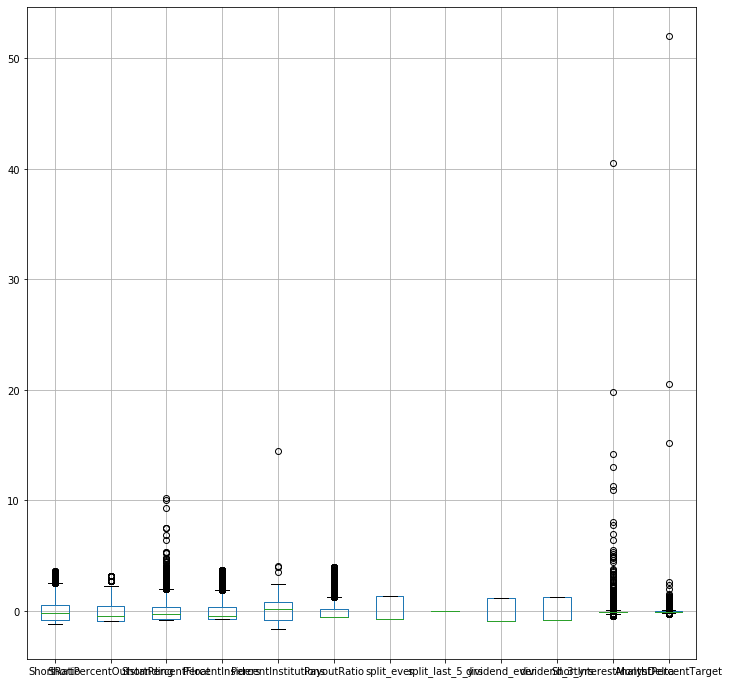

In [1079]:
new_df[['ShortRatio', 'ShortPercentOutstanding', 'ShortPercentFloat',
       'PercentInsiders', 'PercentInstitutions', 'PayoutRatio',
       'split_ever', 'split_last_5_yrs', 'dividend_ever', 'dividend_3_yrs',
       'ShortInterestMonthDelta', 'AnalystPercentTarget']].boxplot(figsize=(12,12))

Training Score: 0.01
Test Score: -421.62
                            OLS Regression Results                            
Dep. Variable:      ReturnOnEquityTTM   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9663
Date:                Thu, 21 Oct 2021   Prob (F-statistic):              0.536
Time:                        22:01:07   Log-Likelihood:                -19482.
No. Observations:                3293   AIC:                         3.906e+04
Df Residuals:                    3247   BIC:                         3.934e+04
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

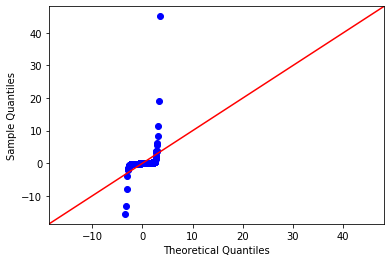

Test for Homoscedasticity


KeyError: "['uarterlyEarningsGrowthYOY', 'uarterlyRevenueGrowthYOY'] not in index"

In [1021]:
RoETTM = base_df.copy()

RoETTM['ReturnOnEquityTTM'].replace({-99999.9900: np.NaN}, inplace=True)

RoETTM_null = RoETTM[RoETTM['ReturnOnEquityTTM'].isna()]
RoETTM_to_model = RoETTM[RoETTM['ReturnOnEquityTTM'].notna()]
RoETTM_to_model = one_h_e(RoETTM_to_model, ['Sector', 'Market-Cap'])
RoETTM_to_model.drop(['Symbol','Name','Description'], axis = 1, inplace=True)

RoETTM_model1, RoETTM_smmodel1 = linear_reg(RoETTM_to_model, 'ReturnOnEquityTTM')

In [975]:
abc.isna().sum()

694

In [969]:
len(abc)

5085

In [905]:
base_df.shape

(5085, 42)

In [903]:
print("Null Rows: ", base_df.isna().sum().sum())

Null Rows:  0


## Clustering

After dropping a few more absolute value metrics we will split the stocks into their respective Market Cap bins. They are often split this way in benchmarks just because of the relative amount of money needed to reach the limit of how much you can own. Funds are limited as to how much of a public company they can own, so larger funds (of several billion plus) usually can't get any impact from smaller cap stocks. This limitation is both because of the 10% limit but also because trading volumes is important; how long does it take to buy up enough shares to fill your desired position? With smaller stocks these numbers are usually lower. 

In [1192]:
clean_df = pd.read_csv('data/clean_df.csv')

clean_df.drop(['Unnamed: 0', 'MarketCapitalization', 'EBITDA', 'GrossProfitTTM', 'RevenueTTM',
              '52WeekHigh', '52WeekLow'], inplace=True, axis =1)

In [1193]:
model_df = clean_df.copy()

model_df.dropna(inplace=True)

model_stocks = model_df[['Symbol', 'Name', 'Description', 'Sector', 'Market-Cap']]

model_df.drop(['Symbol', 'Name', 'Description'], inplace=True, axis =1)

to_ohe = ['Sector', 'Market-Cap']

model_df = one_h_e(model_df, to_ohe)

# Scale for subsequent iterations
model_df_normal = normalize(model_df)
model_df_scaled = pd.DataFrame(model_df_normal, columns=model_df.columns)

In [1194]:
# Determining the number of clusters
k_means_3 = KMeans(n_clusters=3).fit(model_df)
k_means_4 = KMeans(n_clusters=4).fit(model_df)
k_means_5 = KMeans(n_clusters=5).fit(model_df)
k_means_6 = KMeans(n_clusters=6).fit(model_df)
k_means_7 = KMeans(n_clusters=7).fit(model_df)
k_means_8 = KMeans(n_clusters=8).fit(model_df)
k_means_9 = KMeans(n_clusters=9).fit(model_df)
k_means_10 = KMeans(n_clusters=10).fit(model_df)
k_means_11 = KMeans(n_clusters=11).fit(model_df)
k_means_12 = KMeans(n_clusters=12).fit(model_df)
k_means_13 = KMeans(n_clusters=13).fit(model_df)
k_means_14 = KMeans(n_clusters=14).fit(model_df)
k_means_15 = KMeans(n_clusters=15).fit(model_df)
k_means_16 = KMeans(n_clusters=16).fit(model_df)
k_means_17 = KMeans(n_clusters=17).fit(model_df)
k_means_18 = KMeans(n_clusters=18).fit(model_df)
k_means_19 = KMeans(n_clusters=19).fit(model_df)
k_means_20 = KMeans(n_clusters=20).fit(model_df)
k_means_21 = KMeans(n_clusters=21).fit(model_df)
k_means_22 = KMeans(n_clusters=22).fit(model_df)
k_means_23 = KMeans(n_clusters=23).fit(model_df)
k_means_24 = KMeans(n_clusters=24).fit(model_df)
k_means_25 = KMeans(n_clusters=25).fit(model_df)
k_means_26 = KMeans(n_clusters=26).fit(model_df)
k_means_27 = KMeans(n_clusters=27).fit(model_df)
k_means_28 = KMeans(n_clusters=28).fit(model_df)
k_means_29 = KMeans(n_clusters=29).fit(model_df)
k_means_30 = KMeans(n_clusters=30).fit(model_df)

k_list = [k_means_3, k_means_4,k_means_5, k_means_6, k_means_7, k_means_8, 
          k_means_9, k_means_10, k_means_11, k_means_12, k_means_13, k_means_14,
         k_means_15,k_means_16,k_means_17,k_means_18]

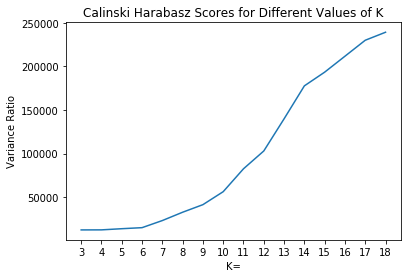

In [1195]:
# Calculate Calinski-Harabasz score for different n of clusters
CH_score = []
for i in k_list:
    label = i.labels_
    CH_score.append(calinski_harabasz_score(model_df, label))

# Plot CH elbow graph
plt.plot(list(range(3,19)), CH_score)
plt.xticks(list(range(3,19)))
plt.title('Calinski Harabasz Scores for Different Values of K')
plt.ylabel('Variance Ratio')
plt.xlabel('K=')
plt.show()

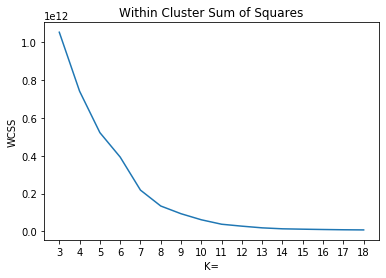

In [1196]:
# Calculate the Within Cluster Sum of Squares for different n clusters
wcss_score = []
for i in k_list:
    wcss_score.append(i.inertia_)

# Plot WCSS elbow graph
plt.plot(list(range(3,19)), wcss_score)
plt.xticks(list(range(3,19)))
plt.title('Within Cluster Sum of Squares')
plt.ylabel('WCSS')
plt.xlabel('K=')
plt.show()

In [1197]:
cluster7_preds = k_means_7.predict(model_df)

In [1198]:
testtest = model_df.copy()

In [1199]:
testtest['preds'] = cluster7_preds

In [1200]:
testtest['preds'].value_counts()

0    5076
3       3
6       2
2       1
5       1
1       1
4       1
Name: preds, dtype: int64

In [1201]:
testtest[['Symbol', 'Name']] = model_stocks[['Symbol', 'Name']]

In [1203]:
agg = model_df_scaled.copy()

agg_clust = AgglomerativeClustering(n_clusters=3)

assigned_clust = agg_clust.fit(agg)

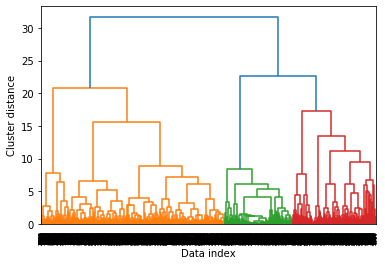

In [1204]:
# Use the ward() function
linkage_array = ward(agg)


# Now we plot the dendrogram for the linkage_array containing the distances
# between clusters
dendrogram(linkage_array)


ax = plt.gca()
bounds = ax.get_xbound()
plt.xlabel('Data index')
plt.ylabel('Cluster distance')
plt.show()

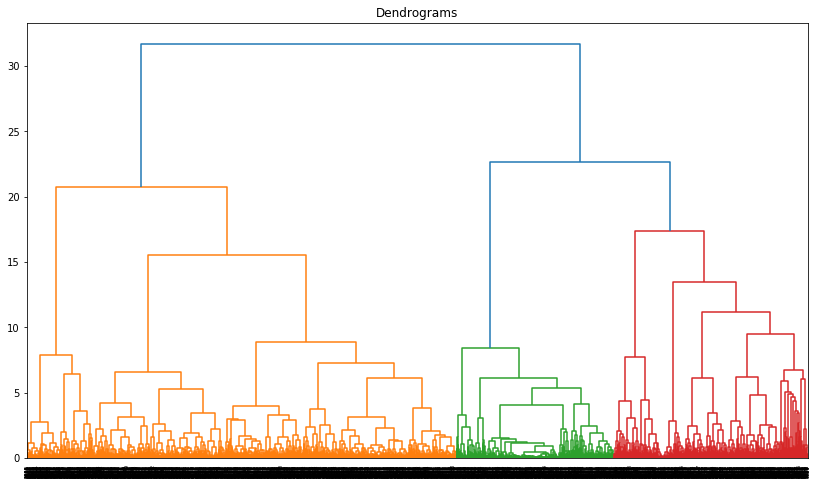

In [1205]:
plt.figure(figsize=(14, 8))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(model_df_scaled, method='ward'))

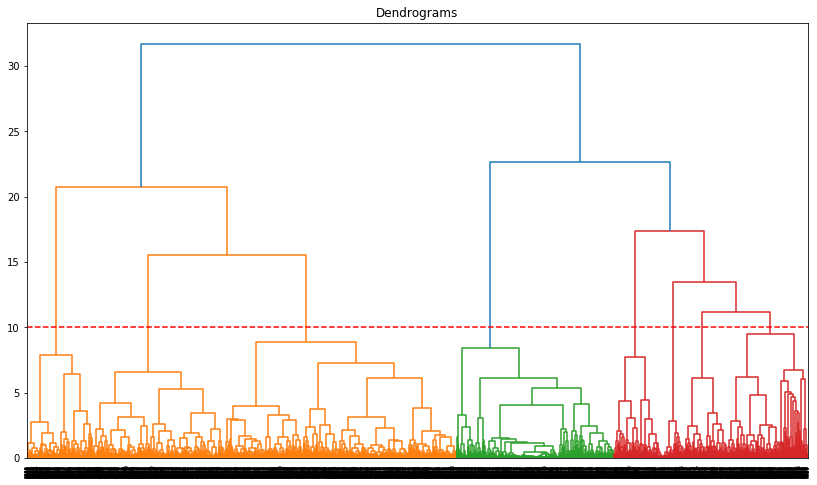

In [1206]:
plt.figure(figsize=(14, 8))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(model_df_scaled, method='ward'))
plt.axhline(y=10, color='r', linestyle='--')


In [1207]:
cluster = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='ward')  
agg_preds = cluster.fit_predict(model_df_scaled)

In [1208]:
unique, counts = np.unique(agg_preds, return_counts=True)

In [1209]:
dict(zip(unique, counts))

{0: 1021,
 1: 429,
 2: 1002,
 3: 187,
 4: 320,
 5: 864,
 6: 144,
 7: 273,
 8: 340,
 9: 505}

In [1211]:
model_df_scaled['predictions'] = agg_preds
agg_model_1 = pd.merge(model_stocks, model_df_scaled, left_index=True, right_index=True)
agg_model_1.drop(['Sector_FINANCE','Sector_LIFE SCIENCES','Sector_MANUFACTURING',
       'Sector_REAL ESTATE & CONSTRUCTION', 'Sector_TECHNOLOGY',
       'Sector_TRADE & SERVICES', 'Market-Cap_Micro-Cap', 'Market-Cap_Mid-Cap',
       'Market-Cap_Small-Cap'], axis=1, inplace=True)

Group : 0


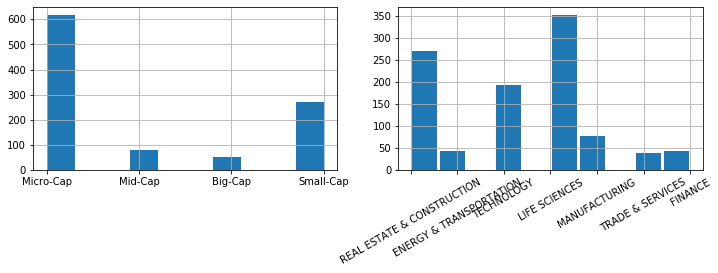

Group : 1


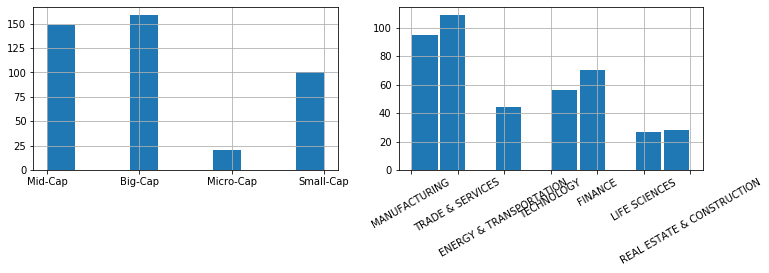

Group : 2


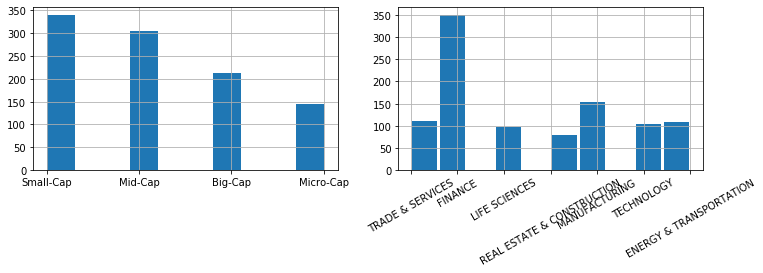

Group : 3


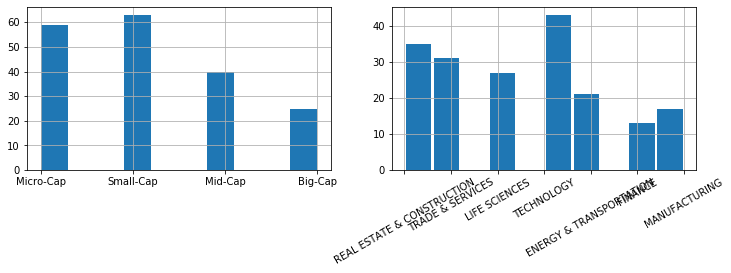

Group : 4


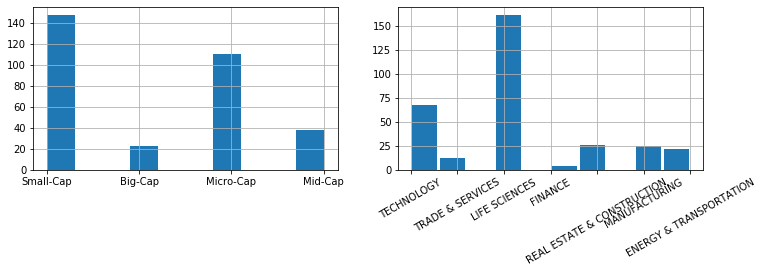

Group : 5


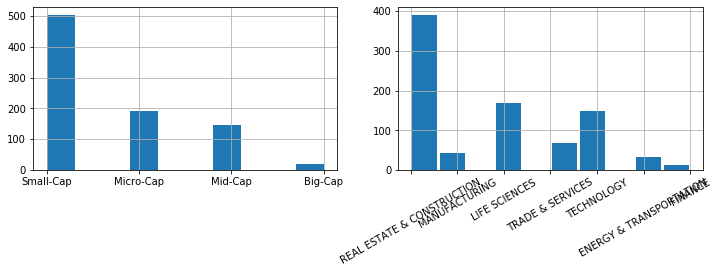

Group : 6


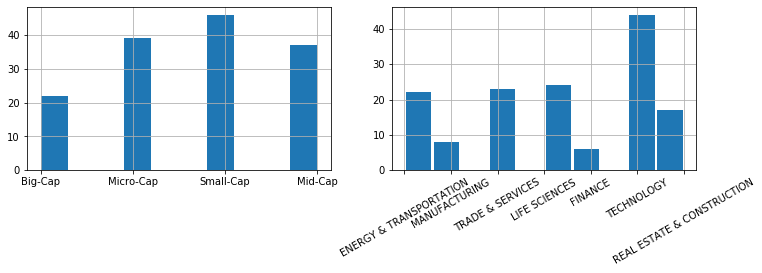

Group : 7


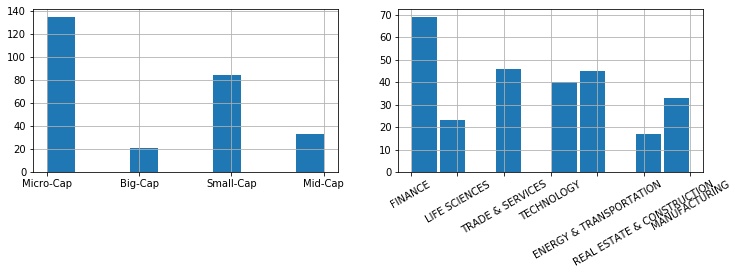

Group : 8


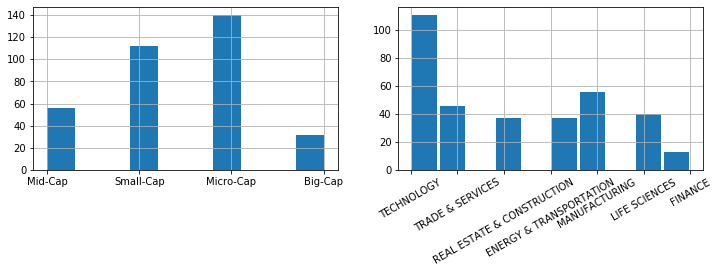

Group : 9


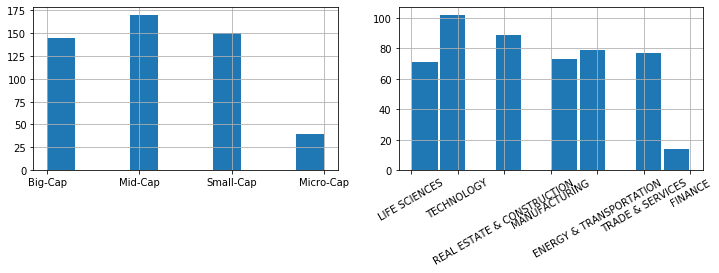

In [1212]:
for i in set(agg_model_1['predictions']):
    print("Group :", i)
    # print(agg_model_1['Sector'][agg_model_1['predictions'] == i].value_counts())
    fig, ax = plt.subplots(ncols=2, figsize=(12,3))
    agg_model_1['Market-Cap'][agg_model_1['predictions'] == i].hist(ax=ax[0])
    agg_model_1['Sector'][agg_model_1['predictions'] == i].hist(ax=ax[1], rwidth=.9)
    plt.xticks(rotation=30)
    plt.show()

### Splitting by Market Cap

Because of the nature of portfolios, it makes sense to split our clustering by Market Capitalization. We will not be looking at Mico Cap stocks because they represent very small companies that do not attract the attention of most Asset Management Companies. 

In [1213]:
# We will not be looking at stocks under 300 million dollars
small_clean_df = clean_df[clean_df['Market-Cap'] == 'Small-Cap']
small_stocks = small_clean_df[['Symbol', 'Name', 'Description', 'Sector']]
small_clean = one_h_e(small_clean_df, 'Sector')
small_clean.drop(['Symbol','Name','Description','Market-Cap'], axis = 1, inplace=True)
small_normal = normalize(small_clean)
small_scaled = pd.DataFrame(small_normal, columns=small_clean.columns)

mid_clean = clean_df[clean_df['Market-Cap'] == 'Mid-Cap']
mid_stocks = mid_clean[['Symbol', 'Name', 'Description', 'Sector']]
mid_clean = one_h_e(mid_clean, 'Sector')
mid_clean.drop(['Symbol','Name','Description','Market-Cap'], axis = 1, inplace=True)
mid_normal = normalize(mid_clean)
mid_scaled = pd.DataFrame(mid_normal, columns=mid_clean.columns)

big_clean = clean_df[clean_df['Market-Cap'] == 'Big-Cap']
big_stocks = big_clean[['Symbol', 'Name', 'Description', 'Sector']]
big_clean = one_h_e(big_clean, 'Sector')
big_clean.drop(['Symbol','Name','Description','Market-Cap'], axis = 1, inplace=True)
big_normal = normalize(big_clean)
big_scaled = pd.DataFrame(big_normal, columns=big_clean.columns)


In [1214]:
print(small_scaled.shape)
print(mid_scaled.shape)
print(big_scaled.shape)

(1816, 37)
(1056, 37)
(712, 37)


### Small-Cap

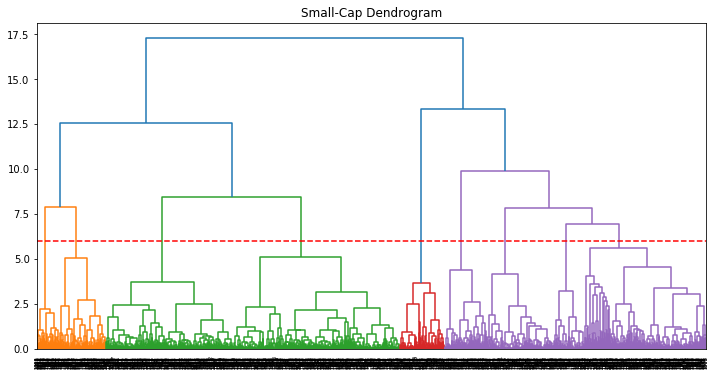

In [1217]:
plt.figure(figsize=(12, 6))  
plt.title("Small-Cap Dendrogram")  
dend = shc.dendrogram(shc.linkage(small_scaled, method='ward'))
plt.axhline(y=6, color='r', linestyle='--')

{0: 329, 1: 453, 2: 126, 3: 120, 4: 117, 5: 344, 6: 179, 7: 85, 8: 63}
Group : 0


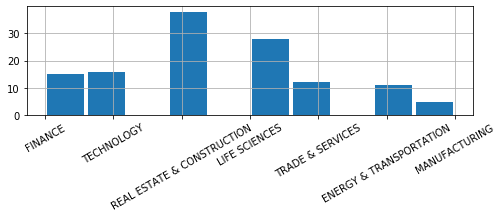

Group : 1


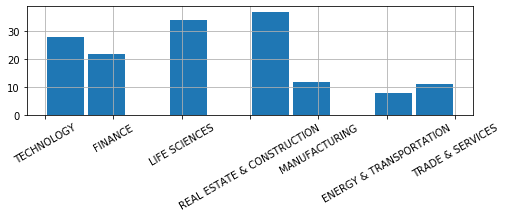

Group : 2


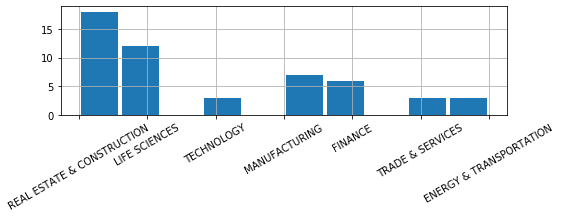

Group : 3


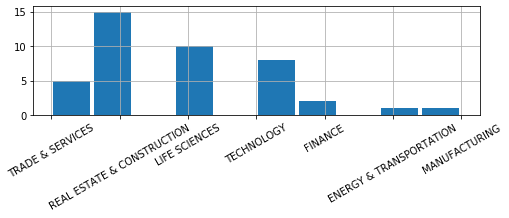

Group : 4


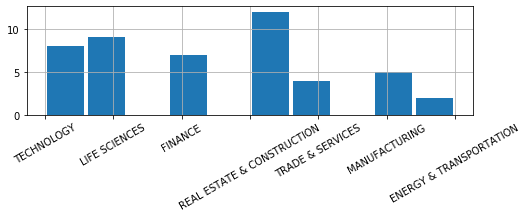

Group : 5


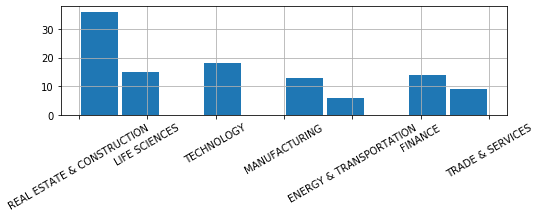

Group : 6


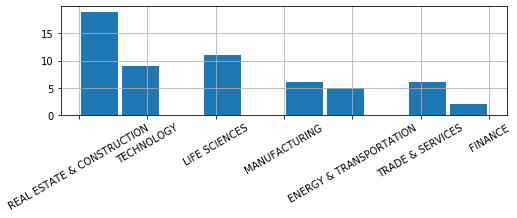

Group : 7


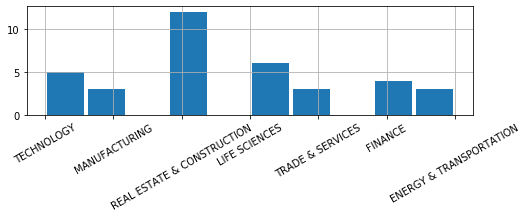

Group : 8


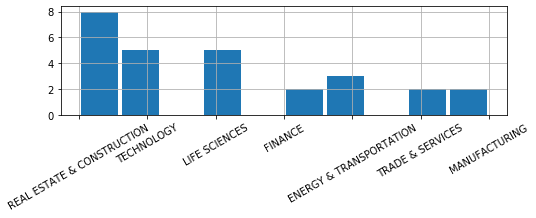

In [1269]:
cluster = AgglomerativeClustering(n_clusters=9, affinity='euclidean', linkage='ward')  
small_agg_preds = cluster.fit_predict(small_scaled)

unique, counts = np.unique(small_agg_preds, return_counts=True)

print(dict(zip(unique, counts)))

small_scaled['predictions'] = small_agg_preds
small_agg_model = pd.merge(small_stocks, small_scaled, left_index=True, right_index=True)
small_agg_model.drop(['FINANCE', 'LIFE SCIENCES', 'MANUFACTURING', 'REAL ESTATE & CONSTRUCTION', 
                      'TECHNOLOGY', 'TRADE & SERVICES'], axis=1, inplace=True)

small_dict = {}
for i in set(small_agg_model['predictions']):
    print("Group :", i)
    small_dict[f"Small-Cap Group {i}"] = [x for x in small_agg_model['Name'][small_agg_model['predictions'] == i].values]
    # print(agg_model_1['Sector'][agg_model_1['predictions'] == i].value_counts())
    fig, ax = plt.subplots(figsize=(8,2))
    small_agg_model['Sector'][small_agg_model['predictions'] == i].hist(rwidth=.9)
    plt.xticks(rotation=30)
    plt.show()

### Mid-Cap

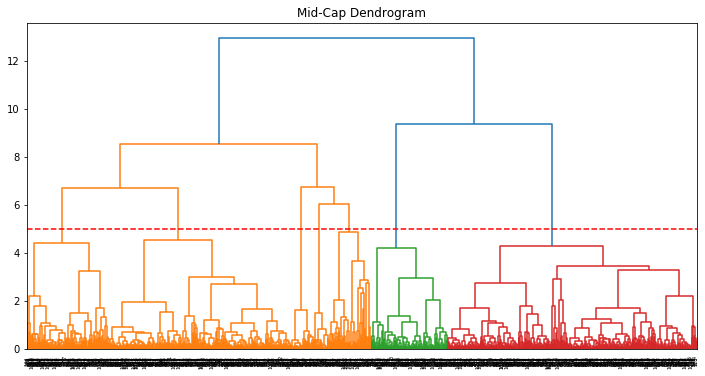

In [1218]:
plt.figure(figsize=(12, 6))  
plt.title("Mid-Cap Dendrogram")  
dend = shc.dendrogram(shc.linkage(mid_scaled, method='ward'))
plt.axhline(y=5, color='r', linestyle='--')

{0: 67, 1: 288, 2: 130, 3: 120, 4: 393, 5: 35, 6: 23}
Group : 0


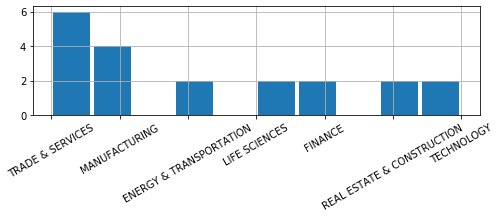

Group : 1


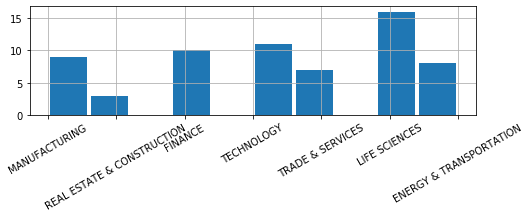

Group : 2


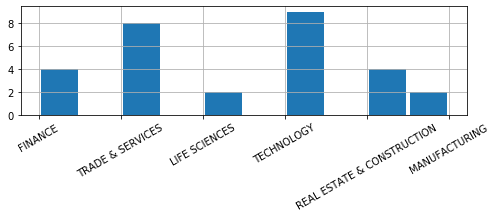

Group : 3


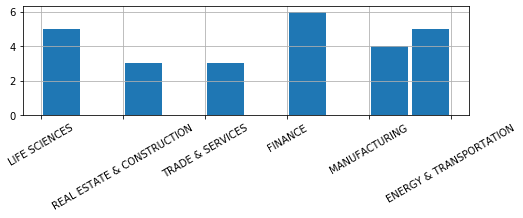

Group : 4


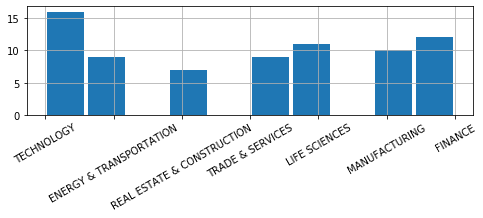

Group : 5


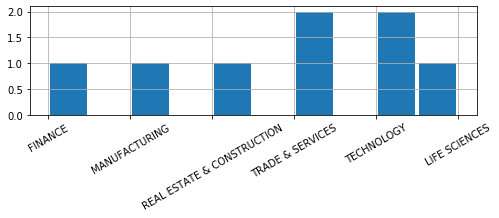

Group : 6


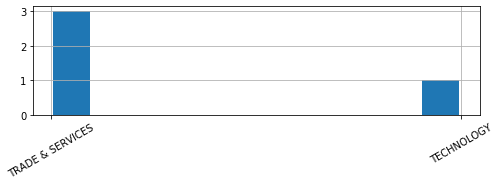

In [1268]:
cluster = AgglomerativeClustering(n_clusters=7, affinity='euclidean', linkage='ward')  
mid_agg_preds = cluster.fit_predict(mid_scaled)

mid_unique, mid_counts = np.unique(mid_agg_preds, return_counts=True)

print(dict(zip(mid_unique, mid_counts)))

mid_scaled['predictions'] = mid_agg_preds
mid_agg_model = pd.merge(mid_stocks, mid_scaled, left_index=True, right_index=True)
mid_agg_model.drop(['FINANCE', 'LIFE SCIENCES', 'MANUFACTURING', 'REAL ESTATE & CONSTRUCTION', 
                      'TECHNOLOGY', 'TRADE & SERVICES'], axis=1, inplace=True)

mid_dict = {}
for i in set(mid_agg_model['predictions']):
    print("Group :", i)
    mid_dict[f"Mid-Cap Group {i}"] = [x for x in mid_agg_model['Name'][mid_agg_model['predictions'] == i].values]
    # print(agg_model_1['Sector'][agg_model_1['predictions'] == i].value_counts())
    fig, ax = plt.subplots(figsize=(8,2))
    mid_agg_model['Sector'][mid_agg_model['predictions'] == i].hist(rwidth=.9)
    plt.xticks(rotation=30)
    plt.show()

### Large-Cap

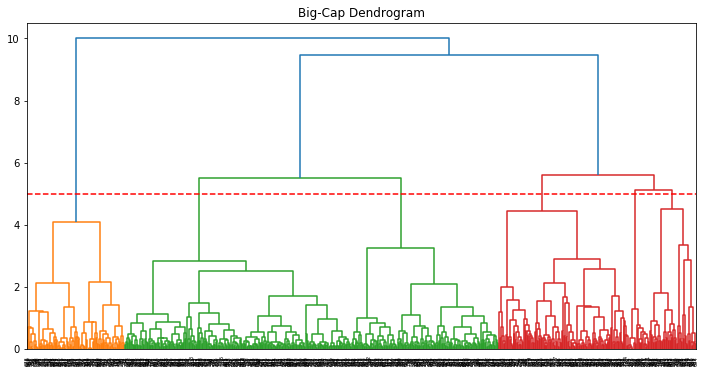

In [1230]:
plt.figure(figsize=(12, 6))  
plt.title("Big-Cap Dendrogram")  
dend = shc.dendrogram(shc.linkage(big_scaled, method='ward'))
plt.axhline(y=5, color='r', linestyle='--')

{0: 50, 1: 138, 2: 104, 3: 241, 4: 157, 5: 22}
Group : 0


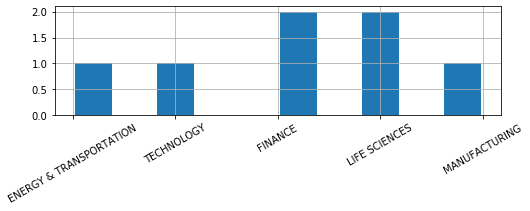

Group : 1


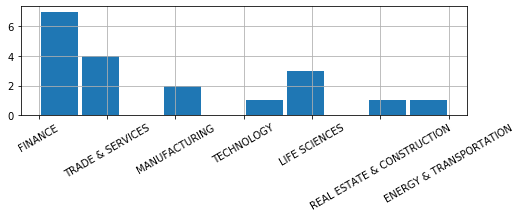

Group : 2


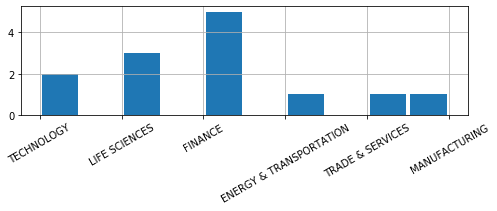

Group : 3


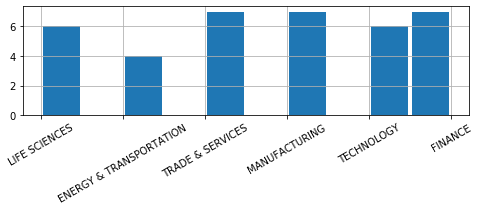

Group : 4


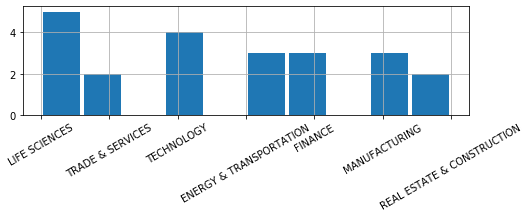

Group : 5


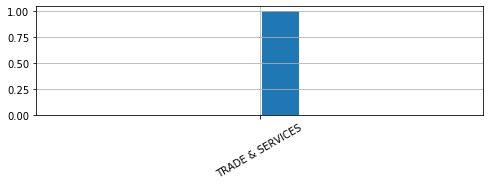

In [1265]:
cluster = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')  
big_agg_preds = cluster.fit_predict(big_scaled)

big_unique, big_counts = np.unique(big_agg_preds, return_counts=True)

print(dict(zip(big_unique, big_counts)))

big_scaled['predictions'] = big_agg_preds
big_agg_model = pd.merge(big_stocks, big_scaled, left_index=True, right_index=True)
big_agg_model.drop(['FINANCE', 'LIFE SCIENCES', 'MANUFACTURING', 'REAL ESTATE & CONSTRUCTION', 
                      'TECHNOLOGY', 'TRADE & SERVICES'], axis=1, inplace=True)

big_dict = {}
for i in set(big_agg_model['predictions']):
    print("Group :", i)
    big_dict[f"Big-Cap Group {i}"] = [x for x in big_agg_model['Name'][big_agg_model['predictions'] == i].values]
    # print(agg_model_1['Sector'][agg_model_1['predictions'] == i].value_counts())
    fig, ax = plt.subplots(figsize=(8,2))
    big_agg_model['Sector'][big_agg_model['predictions'] == i].hist(rwidth=.9)
    plt.xticks(rotation=30)
    plt.show()

In [1270]:
dicts = [small_dict, mid_dict, big_dict]

In [1272]:
dicts[0].keys()

dict_keys(['Small-Cap Group 0', 'Small-Cap Group 1', 'Small-Cap Group 2', 'Small-Cap Group 3', 'Small-Cap Group 4', 'Small-Cap Group 5', 'Small-Cap Group 6', 'Small-Cap Group 7', 'Small-Cap Group 8'])

In [1291]:
for i in dicts:
    for key in i.keys():
        print("\n",key, " - ", len(i[key]), "Stocks :")
        print(i[key])


 Small-Cap Group 0  -  125 Stocks :
['Associated Capital Group Inc', 'Axcelis Technologies Inc', 'Ares Commercial Real Estate Corporation', 'Aclaris Therapeutics Inc', '26 Capital Acquisition Corp', 'Adamas Pharmaceuticals Inc', 'Advent Technologies Holdings Inc', 'Aenza S.A.A', 'American Finance Trust Inc', 'AfterNext HealthTech Acquisition Corp', 'Afya Limited', 'Agenus Inc', 'Agile Growth Corp', 'Arlington Asset Investment Corp. 6.75% SR NT 25', 'Akoya Biosciences Inc', 'Alector Inc', 'Allogene Therapeutics Inc', 'Altimmune Inc', 'Alto Ingredients Inc', 'AMC Networks Inc', 'AssetMark Financial Holdings Inc', 'Amerant Bancorp Inc', 'Applied Molecular Transport Inc', 'Aemetis Inc', 'AnaptysBio Inc', 'The Andersons Inc', 'Angel Oak Mortgage Inc.', 'Alliance Resource Partners L.P', 'Arrow Financial Corporation', 'ARMOUR Residential REIT Inc', 'AdvanSix Inc', 'AerSale Corporation', 'Anterix Inc', 'Athersys Inc', 'Atlanticus Holdings Corporation', 'Astronics Corporation', 'AudioCodes Ltd

## Functions

In [1017]:
def Pearson_Corr_matrix(cleaned_df):
    '''Use this function to print out a Pearson Correlation Matrix for a cleaned dataframe.
    The dataframe should not have any null values'''
    features = [i for i in cleaned_df.columns]

    mask = np.zeros_like(cleaned_df[features].corr(), dtype=np.bool) 
    mask[np.triu_indices_from(mask)] = True 

    f, ax = plt.subplots(figsize=(16, 12))
    plt.title('Pearson Correlation Matrix',fontsize=25)

    sns.heatmap(cleaned_df[features].corr(),annot=True, cmap='BuGn', 
                linecolor="w", mask = mask)
    
    
def print_regplot(cleaned_df, x, y):
    '''Print a regplot for a cleaned dataframe.
    Inputs:
    cleaned_df - try to remove empty rows
    x - the x value you are using to predict y - for selecting x value run Pearson_Corr_matrix
    y - the output value you are trying to fill null values for
    '''
    # Plot using table above
    plt.figure(figsize =(10,6))
    sns.regplot(data= cleaned_df, x= x, y= y,
               marker= '+', x_estimator=np.mean,
               line_kws={"color": "orange"})
    plt.ylabel(y, fontsize = 14)
    plt.xlabel(x, fontsize = 14)
    plt.title(y, fontsize = 17, fontweight = 'bold')
    plt.show()

    the_coeff = np.corrcoef(cleaned_df[x], cleaned_df[y])[0][1]

    #Just in case the visualization is not clear, let's calculate it.
    print("Correlation Coefficient:\n", np.corrcoef(cleaned_df[x], cleaned_df[y]))
    
    return the_coeff


# Function for one-hot encoding
def one_h_e(df, categories, drop_first = True):
    '''Enter datframe and the columns you want to one hot encode'''
    
    df_ohe = df[categories].astype('category')
    
    df_ohe = pd.get_dummies(df_ohe, drop_first = drop_first)
    
    df_done = pd.concat([df, df_ohe], axis = 1)
    
    df_done = df_done.drop(categories, axis = 1)
    
    return df_done


# StepWise Selection for Regression - from course material
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.25, 
                       verbose=True):
    """ 
    Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(included[worst_feature])
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included


# Linear Regression
def stepwise_linear_reg(df, dependent):
    '''Input dataframe and the target (dependent) variable to return a lienar regression model and an OLS regression'''
    
    # Split independent and dependent variables
    X = df.drop(dependent, axis = 1)
    y = df[dependent]
    
    # Split both into 75/25 train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size = 0.75, random_state = 12)
    
    # Create a new training set Dataframe w/ features and target
    kc_train = pd.concat([X_train, y_train], axis = 1)
    # Test Dataframe
    kc_test = pd.concat([X_test, y_test], axis = 1)
    
    # Select features using stepwise_selection
    result = stepwise_selection(X_train, y_train, verbose = False)
    print("Selected Features:")
    print(result)
    
    linreg = LinearRegression()
    model = linreg.fit(X_train, y_train)
    
    # Check the score (R-squared)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    print('Training Score:', round(train_score, 2))
    print('Test Score:', round(test_score, 2))
    
    # Designate input and outcome variables
    outcome = dependent
    x_cols = [f"Q('{i}')" for i in result]
    
    # Create a formula and use it to initiate an ols model 
    predictors = '+'.join(x_cols)
    formula = outcome + '~' + predictors
    smmodel = ols(formula = formula, data=kc_train).fit()
    print(smmodel.summary())
    
    # Test for Normality
    print("\nTest for Normality")
    fig = sm.graphics.qqplot(smmodel.resid, dist=stats.norm, line='45', fit=True)
    plt.show()
    
    # Remove the Q and parentheses from the x_cols object to allow using it with the dataframe
    x_cols_strip = [i.strip("Q()'") for i in x_cols]

    # plot the models homoscedasticity
    print("Test for Homoscedasticity")
    plt.scatter(smmodel.predict(kc_train[x_cols_strip]), smmodel.resid)
    plt.plot(smmodel.predict(kc_train[x_cols_strip]), [0 for i in range(len(kc_train))])
    plt.show()
    
    # plot the residuals distribution
    print("Test for Distribution of Residuals")
    sns.distplot(smmodel.resid)
    plt.show()
    
    return model, smmodel

# EPS Work 

This section was not ended up being used, but the query for pulling the data is almost set up and will likely be useful for future iterations of this project.

In [ ]:
# Set empty dataframe and list
primary = pd.DataFrame([pd.to_datetime(-i, format='%Y').year for i in range(-2021,-1995)], columns=['Year'])
primary.set_index('Year', inplace=True)

no_EPS_data = []

In [ ]:
## Download Earnings Per Share Data for every stock
%%time
counter = 0
for i in clean_df.Symbol:
    url = f'https://www.alphavantage.co/query?function=EARNINGS&symbol={i}&apikey={key_alpha}'
    r = requests.get(url)
    data = r.json()
    
    counter += 1
    if counter%250 == 0:
        print(f"{counter} completed")

    if data['annualEarnings'] == []:
        no_EPS_data.append(i)

    else:
        test = pd.DataFrame(data['annualEarnings'])

        test.columns = ['fiscalDateEnding', i]

        test['Year'] = pd.to_datetime(test['fiscalDateEnding'], format= '%Y-%m-%d').dt.year

        test.drop(['fiscalDateEnding'], axis=1, inplace=True)

        test.set_index('Year', inplace=True)

        primary = primary.merge(test, how='left', left_on='Year', right_on='Year')[-26:]

In [ ]:
# primary.to_csv('data/EPS_data.csv')

## ARCHIVE

In [ ]:
url = 'https://www.alphavantage.co/query?function=CASH_FLOW&symbol=IBM&apikey='+ key_alpha
r = requests.get(url)
cash_flow_IBM = r.json()